##  <u> *Data Modelling*  </u>

In [ ]:
%run 3_EDA.ipynb

---

### <u>*Regression Modelling for severity as a Target Features*</u>


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor,XGBRFRegressor
import warnings
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp


---

#### *B.1*<br> <u>*Basic Models Comparison :*</u>

##### *B.1.1*<br> <u>*Models :*</u>

In [5]:
models = {
                "Random Forest": RandomForestRegressor(random_state=41),
                "Decision Tree": DecisionTreeRegressor(random_state=41),
                "Gradient Boosting": GradientBoostingRegressor(random_state=41),
                "XGBRFRegressor":XGBRFRegressor(random_state=41),
                "CatBoosting Regressor": CatBoostRegressor(verbose=False,random_state=41),
                "AdaBoost Regressor": AdaBoostRegressor(random_state=41),
            }

##### *B.1.2*<br> <u>*Prepare Date :*</u>

In [6]:

x_severity=df.drop("severity",axis=1)
y_severity=df["severity"]

xtrain_full,xtest_full, ytrain, ytest = train_test_split(x_severity, y_severity, train_size=0.8, test_size=0.2,random_state=0)

numerical_cols = [col for col in xtrain_full.columns if xtrain_full[col].dtype in ['int64', 'float64']]
categorical_cols =[col for col in xtrain_full.columns if  xtrain_full[col].dtype == "object"]

my_cols = categorical_cols + numerical_cols
xtrain = xtrain_full[my_cols].copy()
xtest = xtest_full[my_cols].copy()

numerical_transformer = Pipeline(steps=[
    ("scaler",StandardScaler())
    ])


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ("scaler",StandardScaler(with_mean=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

##### *B.1.3*<br> <u>*Apply Models :*</u>

In [7]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square


model_list = []
r2_list =[]
mae_list=[]
rmse_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model =my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne_model', model)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
    model.fit(xtrain, ytrain) 

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    rmse_list.append(model_test_rmse)
    mae_list.append(model_test_mae)
    
    print('='*35)
    print('\n')



Random Forest
Model performance for Training set
- Root Mean Squared Error: 28.1504
- Mean Absolute Error: 0.5953
- R2 Score: 0.9992
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 127.6796
- Mean Absolute Error: 2.7136
- R2 Score: 0.9845


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 81.6631
- Mean Absolute Error: 1.9854
- R2 Score: 0.9936


Gradient Boosting
Model performance for Training set
- Root Mean Squared Error: 14.1260
- Mean Absolute Error: 2.0642
- R2 Score: 0.9998
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 82.9799
- Mean Absolute Error: 3.1708
- R2 Score: 0.9934


XGBRFRegressor
Model performance for Training set
- Root Mean Squared Error: 32.5511
- Mean Absolute Error: 4.3800
- R2 Score: 0.9990
-------

##### *B.1.4*<br> <u>*Best Model :*</u>

In [8]:
pd.DataFrame(list(zip(model_list,rmse_list,mae_list,r2_list)), 
             columns=['Model Name', 'rmse_Score','mae_Score','r2_Score']).sort_values(by=["mae_Score"],ascending=True)

,Model Name,rmse_Score,mae_Score,r2_Score
1,Decision Tree,81.663051,1.985411,0.993640
0,Random Forest,127.679613,2.713639,0.984454
2,Gradient Boosting,82.979904,3.170842,0.993434
4,CatBoosting Regressor,204.555801,4.468886,0.960097
3,XGBRFRegressor,136.417456,6.546190,0.982253
5,AdaBoost Regressor,248.190359,202.697564,0.941257


##### *B.1.5*<br> <u>*Apply Best Model :*</u>

In [9]:
DecisionTreeRegressor_model = DecisionTreeRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne_model', DecisionTreeRegressor_model)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

MAE: 2.1356469201296786
 Accuracy of the model is 99.27


##### *B.1.6*<br> <u>*Visualize Best Model :*</u>

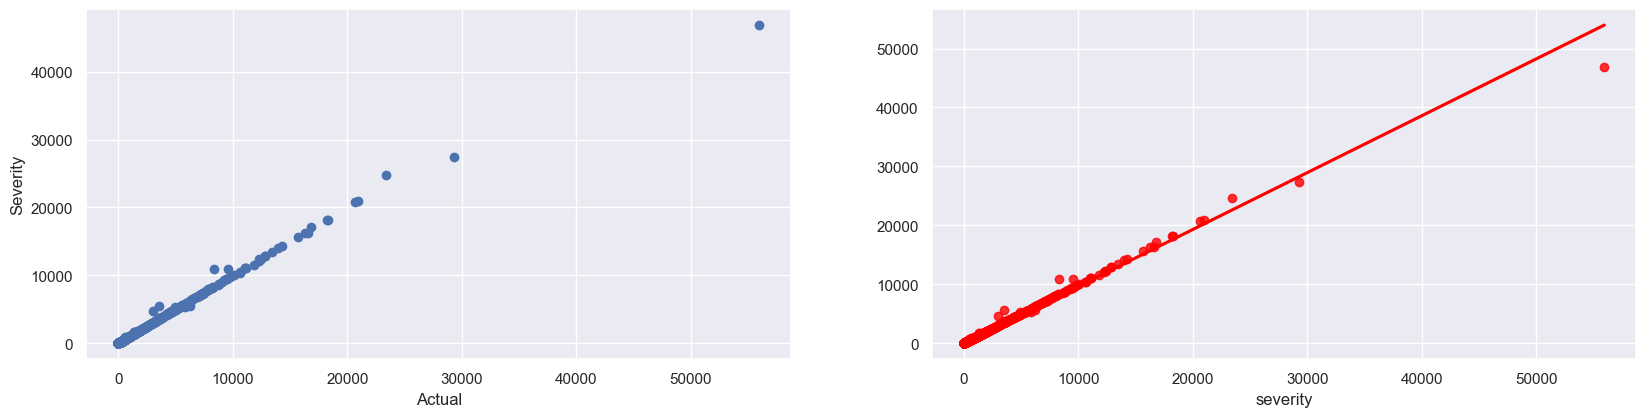

In [10]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('Severity');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

---

#### *B.2*<br> <u>*Hyperopt Models Comparison :*</u>

##### *B.2.1*<br> <u>*Create Spaces for each model :*</u>

In [11]:
space_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }

space_SVR = {
    'C': hp.loguniform('C', -5, 2), 
    'epsilon': hp.loguniform('epsilon', -3, 0), 
    'kernel': hp.choice('kernel', ['linear', 'rbf']) 

}

space_dt = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }

space_XGBRFRegressor = {
  'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
  "learning_rate": hp.uniform("learning_rate", 0, 1),
  'max_depth': hp.choice("max_depth", np.arange(1,20,1)),
  "num_parallel_tree": 100,
  "subsample": hp.uniform("subsample", 0.5,1)
}

space_catboost = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'depth': hp.choice('depth', range(1, 12)),
    'iterations': hp.choice('iterations', range(50, 200)),
}

space_adaboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
}

space_gradientboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', range(1, 12)),
}

##### *B.2.2*<br> <u>*Apply hyperopt :*</u>

In [12]:
def model_catboost(space_catboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(space_catboost['learning_rate']),
                                    depth=int(space_catboost["depth"]),                                                       
                                    iterations=int(space_catboost['iterations'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

def model_rf(space_rf):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(space_rf['n_estimators']),
                                    max_depth=int(space_rf["max_depth"])                                                       
                                    #criterion=str(space_rf['criterion'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }   


#####################################################################

def model_gboost(space_gradientboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(space_gradientboost['n_estimators']),
                                    learning_rate=float(space_gradientboost["learning_rate"]),                                           
                                    max_depth=int(space_gradientboost['max_depth'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

def model_XGBRFRegressor(space_XGBRFRegressor):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(space_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(space_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(space_XGBRFRegressor['max_depth']),
                                    num_parallel_tree=int(space_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(space_XGBRFRegressor['subsample'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }       

#####################################################################

def model_adaboost(space_adaboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(space_adaboost['n_estimators']),
                                    learning_rate=float(space_adaboost["learning_rate"])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

In [13]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost, algo=tpe.suggest, max_evals=50)
best_model_rf = fmin(fn=model_rf, space=space_rf, algo=tpe.suggest, max_evals=50)
best_model_gboost = fmin(fn=model_gboost, space=space_gradientboost, algo=tpe.suggest, max_evals=50)
best_model_XGBRFRegressor = fmin(fn=model_XGBRFRegressor, space=space_XGBRFRegressor, algo=tpe.suggest, max_evals=50)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

0:	learn: 885.5254812	total: 4.8ms	remaining: 748ms
1:	learn: 768.8357561	total: 9.24ms	remaining: 716ms
2:	learn: 666.7804016	total: 12.6ms	remaining: 644ms
3:	learn: 584.6122860	total: 16.1ms	remaining: 616ms
4:	learn: 511.5600115	total: 19.9ms	remaining: 603ms
5:	learn: 448.2267582	total: 23.8ms	remaining: 598ms
6:	learn: 394.4440438	total: 29ms	remaining: 621ms
7:	learn: 346.8927953	total: 32.8ms	remaining: 610ms
8:	learn: 308.0698427	total: 37ms	remaining: 609ms
9:	learn: 276.1077594	total: 40.9ms	remaining: 602ms
10:	learn: 248.8152265	total: 44.6ms	remaining: 592ms
11:	learn: 225.4966366	total: 48.3ms	remaining: 583ms
12:	learn: 206.4645458	total: 52.6ms	remaining: 582ms
13:	learn: 188.7727895	total: 56ms	remaining: 572ms
14:	learn: 175.6380462	total: 59.4ms	remaining: 563ms
15:	learn: 165.0607868	total: 63ms	remaining: 555ms
16:	learn: 154.9079730	total: 67.6ms	remaining: 557ms
17:	learn: 147.6325740	total: 71.2ms	remaining: 550ms
18:	learn: 140.2692047	total: 74.7ms	remaining:

In [14]:
best_model_adaboost = fmin(fn=model_adaboost, space=space_adaboost, algo=tpe.suggest, max_evals=50)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [12:57<00:00, 15.56s/trial, best loss: 37.286290980249575]


##### *B.2.3*<br> <u>*hyperopt best params:*</u>

In [15]:
print("best_model_catboost",best_model_catboost)
print("best_model_rf",best_model_rf)
print("best_model_gboost",best_model_gboost)
print("best_model_XGBRFRegressor",best_model_XGBRFRegressor)
print("best_model_adaboost",best_model_adaboost)

best_model_catboost {'depth': 6, 'iterations': 104, 'learning_rate': 0.17246090855714713}
best_model_rf {'criterion': 1, 'max_depth': 17, 'n_estimators': 18}
best_model_gboost {'learning_rate': 0.08243748499575798, 'max_depth': 5, 'n_estimators': 49}
best_model_XGBRFRegressor {'colsample_bynode': 0.8208525636156797, 'learning_rate': 0.994971913175845, 'max_depth': 10, 'subsample': 0.8863354292267782}
best_model_adaboost {'learning_rate': 0.010461199408414473, 'n_estimators': 6}


##### *B.2.4*<br> <u>*Apply hyperopt best params:*</u>

In [16]:
def model_catboost_best(best_model_catboost ):
    y_CatBoostRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(best_model_catboost ['learning_rate']),
                                    depth=int(best_model_catboost ["depth"]),                                                       
                                    iterations=int(best_model_catboost ['iterations'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_CatBoostRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_catboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_catboost_best is %.2f" %score)

#####################################################################

def model_rf_best(best_model_rf):
    y_RandomForestRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(best_model_rf['n_estimators']),
                                    max_depth=int(best_model_rf["max_depth"])                                                       
                                    #criterion=str(best_model_rf['criterion'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_RandomForestRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_rf_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_rf_best is %.2f" %score) 

#####################################################################

def model_gboost_best(best_model_gboost):
    y_gboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(best_model_gboost['n_estimators']),
                                    learning_rate=float(best_model_gboost["learning_rate"]),                                           
                                    max_depth=int(best_model_gboost['max_depth'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    y_pred = model_opt_best.predict(xtest)
    y_gboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_gboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_gboost_best is %.2f" %score)

#####################################################################

def model_XGBRFRegressor_best(best_model_XGBRFRegressor):
    y_XGBRFRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(best_model_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(best_model_XGBRFRegressor['max_depth']),
                                    # num_parallel_tree=int(best_model_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(best_model_XGBRFRegressor['subsample'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_XGBRFRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_XGBRFRegressor_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_XGBRFRegressor_best is %.2f" %score)

#####################################################################

def model_adaboost_best(best_model_adaboost):
    y_adaboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(best_model_adaboost['n_estimators']),
                                    learning_rate=float(best_model_adaboost["learning_rate"])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_adaboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_adaboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_adaboost_best is %.2f" %score)

##### *B.2.5*<br> <u>*Determine the best model and hyperopt best params:*</u>

In [17]:

model_catboost_best(best_model_catboost)

0:	learn: 875.6572267	total: 6.15ms	remaining: 634ms
1:	learn: 744.9885098	total: 12.3ms	remaining: 626ms
2:	learn: 641.7306287	total: 18.8ms	remaining: 634ms
3:	learn: 549.3252892	total: 24.2ms	remaining: 606ms
4:	learn: 471.9745469	total: 30.6ms	remaining: 607ms
5:	learn: 404.7403522	total: 35.9ms	remaining: 586ms
6:	learn: 349.3878731	total: 41ms	remaining: 569ms
7:	learn: 304.3286864	total: 48ms	remaining: 576ms
8:	learn: 265.8831389	total: 53.4ms	remaining: 563ms
9:	learn: 236.6468398	total: 59.7ms	remaining: 562ms
10:	learn: 211.9922458	total: 66.6ms	remaining: 563ms
11:	learn: 189.6136129	total: 72.4ms	remaining: 555ms
12:	learn: 170.2768545	total: 78.7ms	remaining: 551ms
13:	learn: 154.1706622	total: 84.9ms	remaining: 545ms
14:	learn: 140.2887145	total: 90.3ms	remaining: 536ms
15:	learn: 129.1595565	total: 98.4ms	remaining: 541ms
16:	learn: 119.3568066	total: 104ms	remaining: 534ms
17:	learn: 110.4955264	total: 112ms	remaining: 533ms
18:	learn: 103.0089253	total: 117ms	remainin

In [18]:
model_rf_best(best_model_rf)

model_rf_best MAE: 3.0755436028424548
 Accuracy of the model_rf_best is 98.06


In [19]:
model_gboost_best(best_model_gboost)


model_gboost_best MAE: 5.0819603521436445
 Accuracy of the model_gboost_best is 99.02


In [20]:
model_XGBRFRegressor_best(best_model_XGBRFRegressor)


model_XGBRFRegressor_best MAE: 2.7811341648239964
 Accuracy of the model_XGBRFRegressor_best is 98.77


In [21]:
model_adaboost_best(best_model_adaboost)

model_adaboost_best MAE: 33.53274670670324
 Accuracy of the model_adaboost_best is 91.52


In [22]:
print(f"model_XGBRFRegressor_best(best_model_XGBRFRegressor) ,has the lowest mae with 105.00095882582306 with the best parameters:\n {best_model_XGBRFRegressor}" )

model_XGBRFRegressor_best(best_model_XGBRFRegressor) ,has the lowest mae with 105.00095882582306 with the best parameters:
 {'colsample_bynode': 0.8208525636156797, 'learning_rate': 0.994971913175845, 'max_depth': 10, 'subsample': 0.8863354292267782}


In [23]:
XGBRFRegressor_model = XGBRFRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('XGBRFRegressor_model', XGBRFRegressor(
                                    colsample_bynode=0.8208525636156797,
                                    learning_rate=0.994971913175845,                                           
                                    max_depth=10,
                                    # num_parallel_tree=int(best_model_XGBRFRegressor['num_parallel_tree']),
                                    subsample=0.8863354292267782))
                                    ])

my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

MAE: 2.7811341648239964
 Accuracy of the model is 98.77


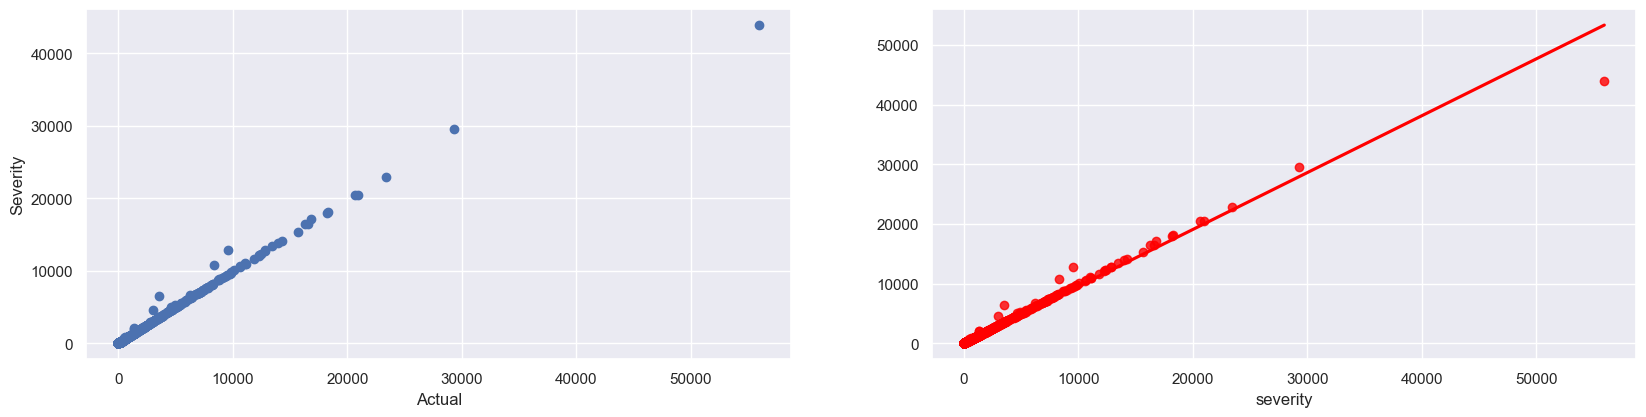

In [24]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('Severity');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

---